<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
### <center> AEGo, ODS Slack nickname: AEGo
    
## <center> Individual data analysis project

**Research plan**
     - Dataset and features description
     - Exploratory data analysis
     - Visual analysis of the features
     - Patterns, insights, pecularities of data
     - Data preprocessing
     - Feature engineering and description
     - Cross-validation, hyperparameter tuning
     - Validation and learning curves
     - Prediction for hold-out and test samples
     - Model evaluation with metrics description
     - Conclusions

In [76]:
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score, precision_score, balanced_accuracy_score
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss, coverage_error
from scipy.sparse import csr_matrix, hstack
from scipy.stats import probplot
import pickle
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
import time
import random
import itertools
from scipy.signal import resample
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from time import gmtime, strftime
from scipy.signal import butter, lfilter
import pywt
from scipy.signal import medfilt

import math
import os

from numpy.random import seed
from tensorflow import set_random_seed

sns.set(style="darkgrid")

import tensorflow as tf

K.clear_session()

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

seed(17)
set_random_seed(17)

### Part 1. Dataset and features description

[ECG Heartbeat Categorization Dataset](https://www.kaggle.com/shayanfazeli/heartbeat)

This dataset is composed of two collections of heartbeat signals derived from two famous datasets in heartbeat classification, the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. 

The signals correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. These signals are preprocessed and segmented, with each segment corresponding to a heartbeat.
Content
Arrhythmia Dataset

| Physionet's MIT-BIH Arrhythmia Dataset | |
|-|-|
| Number of Samples | 109446 |
| Number of Categories | 5 |
| Sampling Frequency | 125Hz |
| Classes |['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4] |

| Class | Description |
|-|-|
| N | Normal |
| S | Supraventricular premature beat |
| V | Premature ventricular contraction |
| F | Fusion of ventricular and normal beat |
| Q | Unclassifiable beat |

    
| Physionet's PTB Diagnostic Database | |
|-|-|
| Number of Samples | 14552 |
| Number of Categories | 2 |
| Sampling Frequency | 125Hz |

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of **188**.

Electrocardiogram (**ECG**) is a graphical representation of the electric activity of the heart and has been commonly used for cardiovascular disease diagnosis.

Data Files

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

In [2]:
PATH = "../../data"
signal_frequency = 125

In [3]:
train_df = pd.read_csv(os.path.join(PATH, 'mitbih_train.csv'), header=None)
test_df = pd.read_csv(os.path.join(PATH, 'mitbih_test.csv'), header=None)
full_df = pd.concat([train_df, test_df], axis=0)

### Part 2. Exploratory data analysis

In [4]:
train_df.shape, test_df.shape

((87554, 188), (21892, 188))

In [5]:
full_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are 109446 samples

In [6]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


##### There are 87554 train samples

In [7]:
train_df[187].value_counts(normalize=True)

0.0    0.827729
4.0    0.073452
2.0    0.066108
1.0    0.025390
3.0    0.007321
Name: 187, dtype: float64

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


##### There are 21892 test samples

In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


In [10]:
test_df[187].value_counts(normalize=True)

0.0    0.827608
4.0    0.073451
2.0    0.066143
1.0    0.025397
3.0    0.007400
Name: 187, dtype: float64

In [11]:
M = full_df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

M_train = train_df.values
XX_train = M_train[:, :-1]
yy_train = M_train[:, -1].astype(int)

M_test = test_df.values
XX_test = M_test[:, :-1]
yy_test = M_test[:, -1].astype(int)

Delete unused variable

In [12]:
del M, M_train, M_test

### Part 3. Visual analysis of the features

In [13]:
def plot_count(data, x, ax, title='Data', xlabel='Class', tick_labesl=['N', 'S', 'V', 'F', 'Q']):
    ax1 = sns.countplot(x=x, data=data, ax=ax)
    ncount = len(data)
    for p in ax1.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax1.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    ax.set_xticklabels(['N', 'S', 'V', 'F', 'Q']);
    ax.set_title(title)
    ax.set_xlabel(xlabel)

Distribution of all data

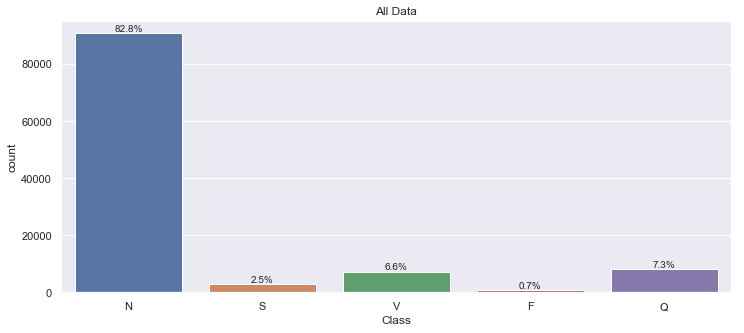

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
plot_count(full_df, 187, ax, title='All Data')

Distribution of train/test data

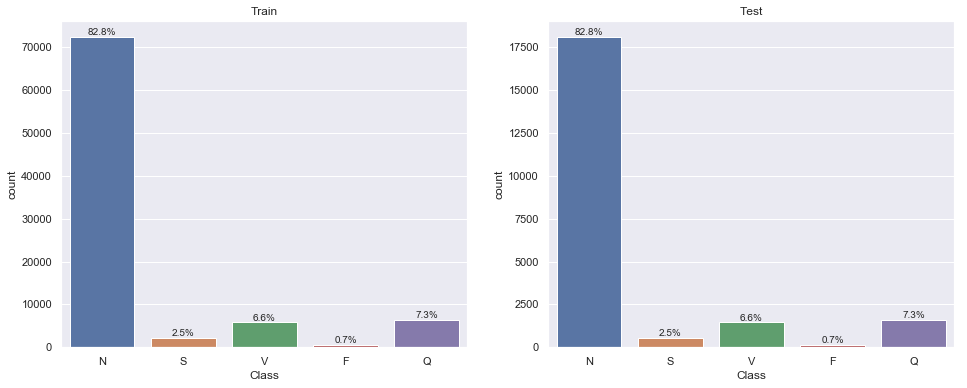

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_count(train_df, 187, ax[0], title='Train')
plot_count(test_df, 187, ax[1], title='Test')

In [16]:
C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

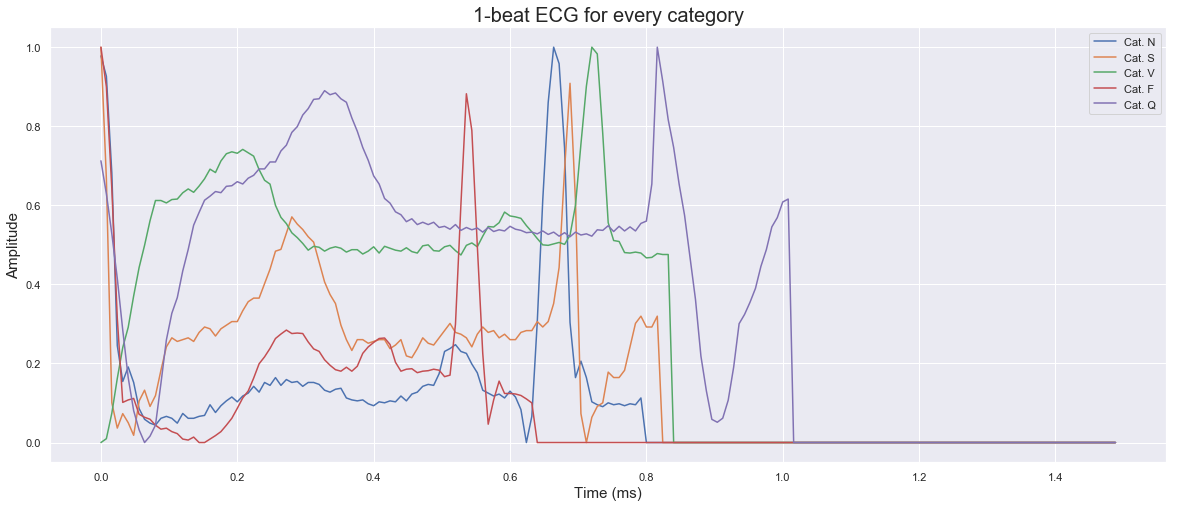

In [17]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,8))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.grid(True)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

### Part 4. Patterns, insights, pecularities of data 

Electrocardiogram (ECG) is a graphical representation of the electric activity of the heart and has been commonly used for cardiovascular disease diagnosis.

**Some usefull functions (plot data, filter data, detect R-peaks, HR (heartrate))**:

In [18]:
from scipy import signal
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):    
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def create_fir_filter(cutoff_hz, fs, n=0, window="hamming"):    
    N = int(fs / 2)
    if n == 0:
        n = N
    return signal.firwin(n, cutoff=cutoff_hz / N, window=window)


def fir_filter(fir, data):
    return lfilter(fir, 1.0, data)

In [19]:
# code from https://github.com/c-labpl/qrs_detector
    
import numpy as np
import matplotlib.pyplot as plt
from time import gmtime, strftime
from scipy.signal import butter, lfilter


LOG_DIR = "logs/"
PLOT_DIR = "plots/"


class QRSDetectorOffline(object):
    """
    Python Offline ECG QRS Detector based on the Pan-Tomkins algorithm.
    
    Michał Sznajder (Jagiellonian University) - technical contact (msznajder@gmail.com)
    Marta Łukowska (Jagiellonian University)


    The module is offline Python implementation of QRS complex detection in the ECG signal based
    on the Pan-Tomkins algorithm: Pan J, Tompkins W.J., A real-time QRS detection algorithm,
    IEEE Transactions on Biomedical Engineering, Vol. BME-32, No. 3, March 1985, pp. 230-236.

    The QRS complex corresponds to the depolarization of the right and left ventricles of the human heart. It is the most visually obvious part of the ECG signal. QRS complex detection is essential for time-domain ECG signal analyses, namely heart rate variability. It makes it possible to compute inter-beat interval (RR interval) values that correspond to the time between two consecutive R peaks. Thus, a QRS complex detector is an ECG-based heart contraction detector.

    Offline version detects QRS complexes in a pre-recorded ECG signal dataset (e.g. stored in .csv format).

    This implementation of a QRS Complex Detector is by no means a certified medical tool and should not be used in health monitoring. It was created and used for experimental purposes in psychophysiology and psychology.

    You can find more information in module documentation:
    https://github.com/c-labpl/qrs_detector

    If you use these modules in a research project, please consider citing it:
    https://zenodo.org/record/583770

    If you use these modules in any other project, please refer to MIT open-source license.


    MIT License

    Copyright (c) 2017 Michał Sznajder, Marta Łukowska

    Permission is hereby granted, free of charge, to any person obtaining a copy
    of this software and associated documentation files (the "Software"), to deal
    in the Software without restriction, including without limitation the rights
    to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
    copies of the Software, and to permit persons to whom the Software is
    furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in all
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
    IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
    FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
    AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
    LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
    OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
    SOFTWARE.
    """

    def __init__(self, ecg_data_path, ecg_data_raw=None, signal_frequency=125,
                 filter_lowcut=0.1, filter_highcut=15.0, filter_order=1,
                 verbose=True, log_data=False, plot_data=False, show_plot=False,
                save_plot=False):
        """
        QRSDetectorOffline class initialisation method.
        :param string ecg_data_path: path to the ECG dataset
        :param bool verbose: flag for printing the results
        :param bool log_data: flag for logging the results
        :param bool plot_data: flag for plotting the results to a file
        :param bool show_plot: flag for showing generated results plot - will not show anything if plot is not generated
        """
        # Configuration parameters.
        self.ecg_data_path = ecg_data_path

        self.signal_frequency = signal_frequency  # Set ECG device frequency in samples per second here.

        self.filter_lowcut = filter_lowcut
        self.filter_highcut = filter_highcut
        self.filter_order = filter_order

        self.integration_window = 8  #15  # Change proportionally when adjusting frequency (in samples).

        self.findpeaks_limit = 0.35
        self.findpeaks_spacing = 25  #50  # Change proportionally when adjusting frequency (in samples).

        self.refractory_period = 60  #120  # Change proportionally when adjusting frequency (in samples).
        self.qrs_peak_filtering_factor = 0.125
        self.noise_peak_filtering_factor = 0.125
        self.qrs_noise_diff_weight = 0.25

        # Loaded ECG data.
        self.ecg_data_raw = None

        # Measured and calculated values.
        self.filtered_ecg_measurements = None
        self.differentiated_ecg_measurements = None
        self.squared_ecg_measurements = None
        self.integrated_ecg_measurements = None
        self.detected_peaks_indices = None
        self.detected_peaks_values = None

        self.qrs_peak_value = 0.0
        self.noise_peak_value = 0.0
        self.threshold_value = 0.0

        # Detection results.
        self.qrs_peaks_indices = np.array([], dtype=int)
        self.noise_peaks_indices = np.array([], dtype=int)

        # Final ECG data and QRS detection results array - samples with detected QRS are marked with 1 value.
        self.ecg_data_detected = None

        # Run whole detector flow.
        if ecg_data_raw is not None:
            self.ecg_data_raw = ecg_data_raw 
        else:    
            self.load_ecg_data()
        self.detect_peaks()
        self.detect_qrs()

        if verbose:
            self.print_detection_data()

        if log_data:
            self.log_path = "{:s}QRS_offline_detector_log_{:s}.csv".format(LOG_DIR,
                                                                           strftime("%Y_%m_%d_%H_%M_%S", gmtime()))
            self.log_detection_data()

        if plot_data:
            self.plot_path = "{:s}QRS_offline_detector_plot_{:s}.png".format(PLOT_DIR,
                                                                             strftime("%Y_%m_%d_%H_%M_%S", gmtime()))
            self.plot_detection_data(show_plot=show_plot, save_plot=save_plot)

    """Loading ECG measurements data methods."""

    def load_ecg_data(self):
        """
        Method loading ECG data set from a file.
        """
        self.ecg_data_raw = np.loadtxt(self.ecg_data_path, skiprows=1, delimiter=',')

    """ECG measurements data processing methods."""

    def detect_peaks(self):
        """
        Method responsible for extracting peaks from loaded ECG measurements data through measurements processing.
        """
        # Extract measurements from loaded ECG data.
        ecg_measurements = self.ecg_data_raw#[:, 1]

        # Measurements filtering - 0-15 Hz band pass filter.
        self.filtered_ecg_measurements = self.bandpass_filter(ecg_measurements.flatten(), 
                                                              lowcut=self.filter_lowcut,
                                                              highcut=self.filter_highcut, 
                                                              signal_freq=self.signal_frequency,
                                                              filter_order=self.filter_order)
#         self.filtered_ecg_measurements[:5] = self.filtered_ecg_measurements[5]

        # Derivative - provides QRS slope information.
        self.differentiated_ecg_measurements = np.ediff1d(self.filtered_ecg_measurements)

        # Squaring - intensifies values received in derivative.
        self.squared_ecg_measurements = self.differentiated_ecg_measurements ** 2

        # Moving-window integration.
        self.integrated_ecg_measurements = np.convolve(
            self.squared_ecg_measurements, 
            np.ones(self.integration_window))

        # Fiducial mark - peak detection on integrated measurements.
        self.detected_peaks_indices = self.findpeaks(data=self.integrated_ecg_measurements,
                                                     limit=self.findpeaks_limit,
                                                     spacing=self.findpeaks_spacing)

        self.detected_peaks_values = self.integrated_ecg_measurements[self.detected_peaks_indices]

    """QRS detection methods."""

    def detect_qrs(self):
        """
        Method responsible for classifying detected ECG measurements peaks either as noise or as QRS complex (heart beat).
        """
        if self.detected_peaks_indices is None:
            return;
        for detected_peak_index, detected_peaks_value in zip(self.detected_peaks_indices, self.detected_peaks_values):

            try:
                last_qrs_index = self.qrs_peaks_indices[-1]
            except IndexError:
                last_qrs_index = 0

            # After a valid QRS complex detection, there is a 200 ms refractory period before next one can be detected.
            if detected_peak_index - last_qrs_index > self.refractory_period or not self.qrs_peaks_indices.size:
                # Peak must be classified either as a noise peak or a QRS peak.
                # To be classified as a QRS peak it must exceed dynamically set threshold value.
                if detected_peaks_value > self.threshold_value:
                    self.qrs_peaks_indices = np.append(self.qrs_peaks_indices, detected_peak_index)

                    # Adjust QRS peak value used later for setting QRS-noise threshold.
                    self.qrs_peak_value = self.qrs_peak_filtering_factor * detected_peaks_value + \
                                          (1 - self.qrs_peak_filtering_factor) * self.qrs_peak_value
                else:
                    self.noise_peaks_indices = np.append(self.noise_peaks_indices, detected_peak_index)

                    # Adjust noise peak value used later for setting QRS-noise threshold.
                    self.noise_peak_value = self.noise_peak_filtering_factor * detected_peaks_value + \
                                            (1 - self.noise_peak_filtering_factor) * self.noise_peak_value

                # Adjust QRS-noise threshold value based on previously detected QRS or noise peaks value.
                self.threshold_value = self.noise_peak_value + \
                                       self.qrs_noise_diff_weight * (self.qrs_peak_value - self.noise_peak_value)

        # Create array containing both input ECG measurements data and QRS detection indication column.
        # We mark QRS detection with '1' flag in 'qrs_detected' log column ('0' otherwise).
        measurement_qrs_detection_flag = np.zeros([len(self.ecg_data_raw), 1])
        measurement_qrs_detection_flag[self.qrs_peaks_indices] = 1
        self.ecg_data_detected = np.append(self.ecg_data_raw, measurement_qrs_detection_flag, 1)

    """Results reporting methods."""

    def print_detection_data(self):
        """
        Method responsible for printing the results.
        """
        print("qrs peaks indices")
        print(self.qrs_peaks_indices)
        print("noise peaks indices")
        print(self.noise_peaks_indices)

    def log_detection_data(self):
        """
        Method responsible for logging measured ECG and detection results to a file.
        """
        with open(self.log_path, "wb") as fin:
            fin.write(b"timestamp,ecg_measurement,qrs_detected\n")
            np.savetxt(fin, self.ecg_data_detected, delimiter=",")

    def plot_detection_data(self, show_plot=False, save_plot=False):
        """
        Method responsible for plotting detection results.
        :param bool show_plot: flag for plotting the results and showing plot
        """
        def plot_data(axis, data, title='', fontsize=10):
            axis.set_title(title, fontsize=fontsize)
            axis.grid(which='both', axis='both', linestyle='--')
            axis.plot(data, color="salmon", zorder=1)

        def plot_points(axis, values, indices):
            axis.scatter(x=indices, y=values[indices], c="black", s=50, zorder=2)

        plt.close('all')
        fig, axarr = plt.subplots(6, sharex=True, figsize=(15, 18))

        plot_data(axis=axarr[0], data=self.ecg_data_raw, title='Raw ECG measurements')
        plot_data(axis=axarr[1], data=self.filtered_ecg_measurements, title='Filtered ECG measurements')
        plot_data(axis=axarr[2], data=self.differentiated_ecg_measurements, title='Differentiated ECG measurements')
        plot_data(axis=axarr[3], data=self.squared_ecg_measurements, title='Squared ECG measurements')
        plot_data(axis=axarr[4], data=self.integrated_ecg_measurements, title='Integrated ECG measurements with QRS peaks marked (black)')
        plot_points(axis=axarr[4], values=self.integrated_ecg_measurements, indices=self.qrs_peaks_indices)
        plot_data(axis=axarr[5], data=self.ecg_data_detected[:, 1], title='Raw ECG measurements with QRS peaks marked (black)')
        plot_points(axis=axarr[5], values=self.ecg_data_detected[:, 1], indices=self.qrs_peaks_indices)

        plt.tight_layout()
        if save_plot:
            fig.savefig(self.plot_path)

        if show_plot:
            plt.show()

        plt.close()

    """Tools methods."""

    def bandpass_filter(self, data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

    def findpeaks(self, data, spacing=1, limit=None):
        """
        Janko Slavic peak detection algorithm and implementation.
        https://github.com/jankoslavic/py-tools/tree/master/findpeaks
        Finds peaks in `data` which are of `spacing` width and >=`limit`.
        :param ndarray data: data
        :param float spacing: minimum spacing to the next peak (should be 1 or more)
        :param float limit: peaks should have value greater or equal
        :return array: detected peaks indexes array
        """
        len = data.size
        x = np.zeros(len + 2 * spacing)
        x[:spacing] = data[0] - 1.e-6
        x[-spacing:] = data[-1] - 1.e-6
        x[spacing:spacing + len] = data
        peak_candidate = np.zeros(len)
        peak_candidate[:] = True
        for s in range(spacing):
            start = spacing - s - 1
            h_b = x[start: start + len]  # before
            start = spacing
            h_c = x[start: start + len]  # central
            start = spacing + s + 1
            h_a = x[start: start + len]  # after
            peak_candidate = np.logical_and(peak_candidate, np.logical_and(h_c > h_b, h_c > h_a))

        ind = np.argwhere(peak_candidate)
        ind = ind.reshape(ind.size)
        if limit is not None:
            ind = ind[data[ind] > limit]
        return ind

In [20]:
class FilterHelper():
    def __init__(self, 
                 signal_frequency=125,
                 filter_lowcut=0.01, 
                 filter_highcut=50.0, 
                 filter_order=1,
                 cutoff_hz=15.0,
                 verbose=False, 
                 log_data=False, 
                 plot_data=False, 
                 show_plot=False,
                 save_plot=False):
        self.signal_frequency = signal_frequency
        self.filter_lowcut = filter_lowcut
        self.filter_highcut = filter_highcut
        self.filter_order = filter_order
        self.cutoff_hz=cutoff_hz
        self.verbose=verbose 
        self.log_data=log_data
        self.plot_data=plot_data
        self.show_plot=show_plot
        self.save_plot=save_plot
        
    def rr_peaks_detect(self, x):
        qrs_detector = QRSDetectorOffline(ecg_data_raw=x.reshape(-1,1), 
                                          filter_lowcut=self.filter_lowcut,
                                          filter_highcut=self.filter_highcut,
                                          filter_order=self.filter_order,
                                          signal_frequency=self.signal_frequency,
                                          ecg_data_path=None, 
                                          verbose=self.verbose,
                                          log_data=self.log_data, 
                                          plot_data=self.plot_data, 
                                          show_plot=self.show_plot)
        return qrs_detector

    def qrs_filter(self, x):
        qrs_detector = QRSDetectorOffline(ecg_data_raw=x.reshape(-1,1), 
                                          filter_lowcut=self.filter_lowcut,
                                          filter_highcut=self.filter_highcut,
                                          filter_order=self.filter_order,
                                          signal_frequency=self.signal_frequency,
                                          ecg_data_path=None, 
                                          verbose=self.verbose,
                                          log_data=self.log_data, 
                                          plot_data=self.plot_data, 
                                          show_plot=self.show_plot)
        return qrs_detector.filtered_ecg_measurements.flatten()

    def fir_filter(self, x):
        # The cutoff frequency of the filter.
        flt = create_fir_filter(self.cutoff_hz, self.signal_frequency)
        return fir_filter(flt, x)

    def bandpass_filter(self, x):
        return butter_bandpass_filter(
            x, 
            self.filter_lowcut, 
            self.filter_highcut, 
            self.signal_frequency, 
            order=self.filter_order)
    
    def compose_filters(self, x):
        return self.fir_filter(self.bandpass_filter(x))
    
def calculate_heart_rate(qrs_detector, signal_frequency=125):
    sec_per_minute = 60
    hr = 0
    i1 = qrs_detector.qrs_peaks_indices[0] if len(qrs_detector.qrs_peaks_indices) > 0 else 0
    i2 = qrs_detector.qrs_peaks_indices[1] if len(qrs_detector.qrs_peaks_indices) > 1 else 0
    if len(qrs_detector.qrs_peaks_indices) > 1:
        hr = signal_frequency / (i2 - i1) * sec_per_minute
    return hr, i1, i2

def plot_ecg(data, filter_helper=None, show_filtered=True, show_hr=True, title='ECG', ax=None):
    if ax is not None:
        plt.axes(ax)
    else:
        plt.figure(figsize=(20,6))
        
    if show_filtered:
        flt = filter_function(data)
        
    plt.plot(data, color='b', label='Original ECG')
    
    if show_hr:
        qrsdetector = filter_helper.rr_peaks_detect(data)
        hr, i1, i2 = calculate_heart_rate(qrsdetector)
        print('Heart Rate: {}, R1: {}, R2: {}'.format(hr, i1, i2))

        plt.scatter(x=qrsdetector.qrs_peaks_indices, 
                    y=qrsdetector.ecg_data_detected[:, 1][qrsdetector.qrs_peaks_indices], 
                    c="black", 
                    s=50, 
                    zorder=2)

    if show_filtered:
        plt.plot(flt, color='r', label='Filtered')
    plt.title(title, fontsize=16)
    plt.grid(True)
    plt.legend()
    if ax is None:
        plt.show();

#### Examples of ECG for each class

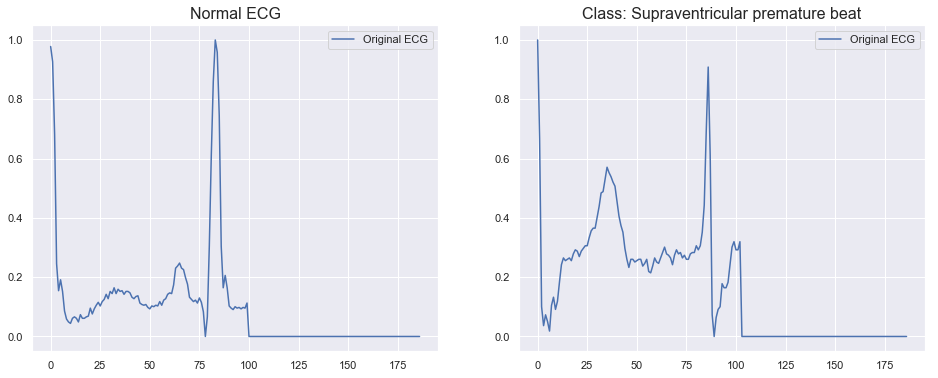

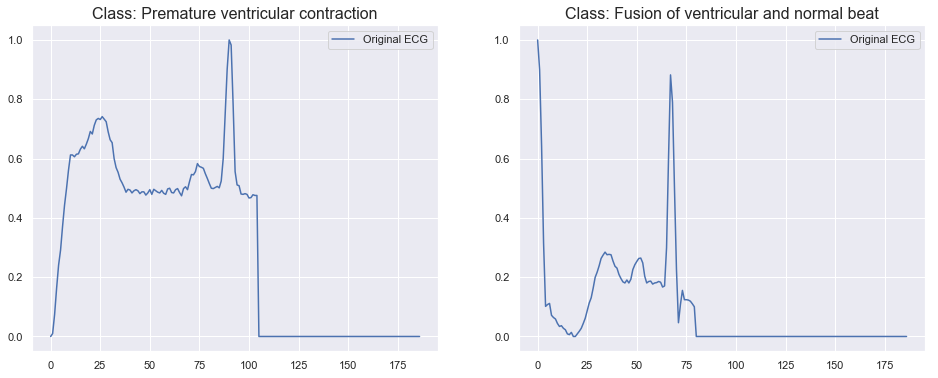

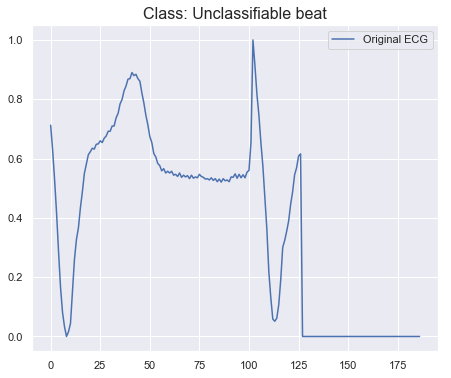

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_ecg(X[np.argwhere(y==0)[0][0], :], ax=axes[0],
         title='Normal ECG', show_filtered=False, show_hr=False)
plot_ecg(X[np.argwhere(y==1)[0][0], :], ax=axes[1],
         title='Class: Supraventricular premature beat', 
         show_filtered=False, show_hr=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_ecg(X[np.argwhere(y==2)[0][0], :], ax=axes[0],
         title='Class: Premature ventricular contraction', 
         show_filtered=False, show_hr=False)
plot_ecg(X[np.argwhere(y==3)[0][0], :], ax=axes[1],
         title='Class: Fusion of ventricular and normal beat', 
         show_filtered=False, show_hr=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_ecg(X[np.argwhere(y==4)[0][0], :], ax=axes[0],
         title='Class: Unclassifiable beat', 
         show_filtered=False, show_hr=False)
fig.delaxes(axes[1])

### Part 5. Data preprocessing

The baseline of the signal is substracted. Additionally, some noise removal can be done.

Two median filters are applied for this purpose.
Some ideas from [this site](https://github.com/mondejar/ecg-classification).

In [22]:
def baseline_ecg(ecg):
    # Remove Baseline
    baseline = medfilt(ecg, 71) 
    baseline = medfilt(baseline, 215) 
    return ecg - baseline

Example of ECG with substracted baseline:

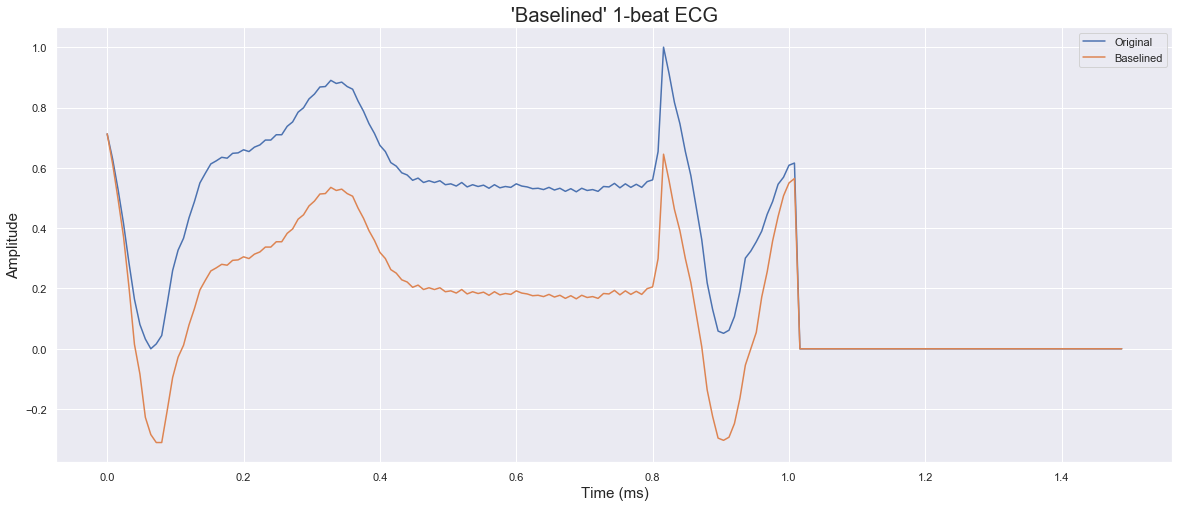

In [23]:
orig_ecg = X[C4, :][0]

flt_bl =  baseline_ecg(orig_ecg)
        
plt.figure(figsize=(20,8))
plt.plot(x, orig_ecg, label="Original")
plt.plot(x, flt_bl, label="Baselined")
plt.legend()
plt.title("'Baselined' 1-beat ECG", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.grid(True)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [24]:
XX_train_bl = np.apply_along_axis(baseline_ecg, 1, XX_train)
XX_test_bl = np.apply_along_axis(baseline_ecg, 1, XX_test)

In [25]:
XX_train_bl.shape, XX_train.shape, XX_test.shape, XX_test_bl.shape

((87554, 187), (87554, 187), (21892, 187), (21892, 187))

**Data augmentation**

To train properly the model, we sould have to augment all data to the same level. Nevertheless, for a first try, we will just augment the smallest class to the same level as class 1.


In [26]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

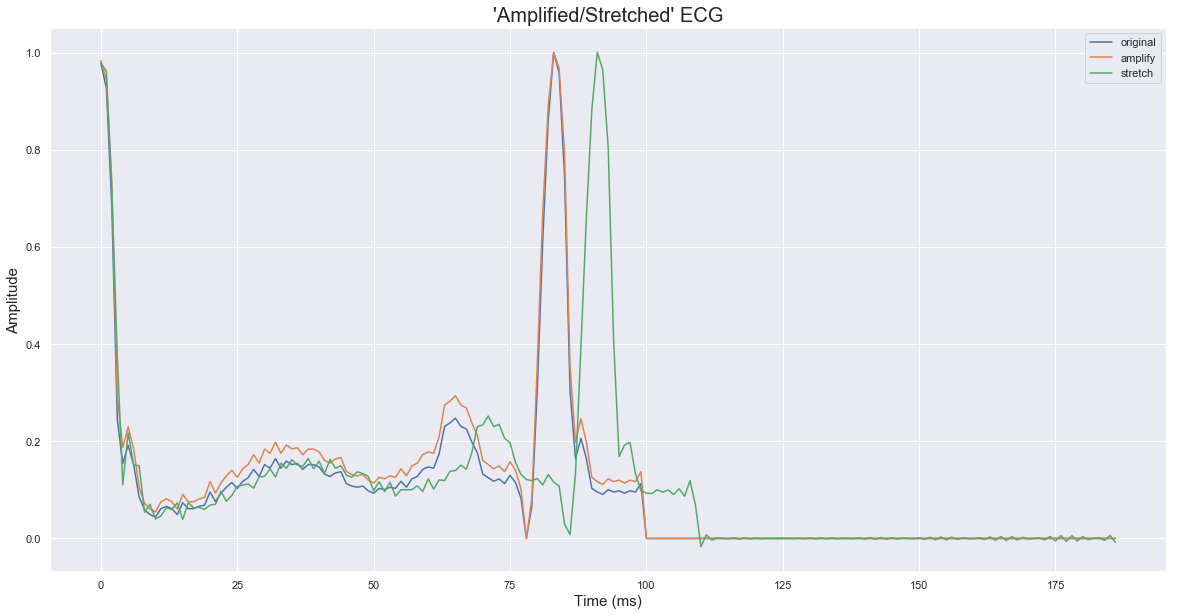

In [27]:
plt.figure(figsize=(20,10))
plt.plot(X[0, :], label='original')
plt.plot(amplify(X[0, :]), label='amplify')
plt.plot(stretch(X[0, :]), label='stretch')
plt.title("'Amplified/Stretched' ECG", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

In [28]:
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)
classes = np.ones(shape=(result.shape[0],), dtype=int)*3
X = np.vstack([X, result])
y = np.hstack([y, classes])

In [29]:
subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [30]:
use800_test = False

In [31]:
if use800_test:
    X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
    y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

    X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
    y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)
else:
    X_test_orig = XX_test
    X_test = XX_test_bl #XX_test
    y_test = yy_test

    X_train_orig = XX_train
    X_train = XX_train_bl #XX_train
    y_train = yy_train

X_train, y_train, X_train_orig = shuffle(X_train, y_train, X_train_orig, random_state=17)
X_test, y_test, X_test_orig = shuffle(X_test, y_test, X_test_orig, random_state=17)


del X
del y
del XX_train, XX_test, XX_train_bl, XX_test_bl

#### X_train_orig, X_test_orig - original(raw) data

#### X_train, X_test - 'baselined' data

In [32]:
ptrain_df = pd.DataFrame(y_train, columns=['class'])
ptest_df = pd.DataFrame(y_test, columns=['class'])

Class counts of train/test data

In [33]:
print(ptrain_df['class'].value_counts())

0    72471
4     6431
2     5788
1     2223
3      641
Name: class, dtype: int64


In [34]:
print(ptest_df['class'].value_counts())

0    18118
4     1608
2     1448
1      556
3      162
Name: class, dtype: int64


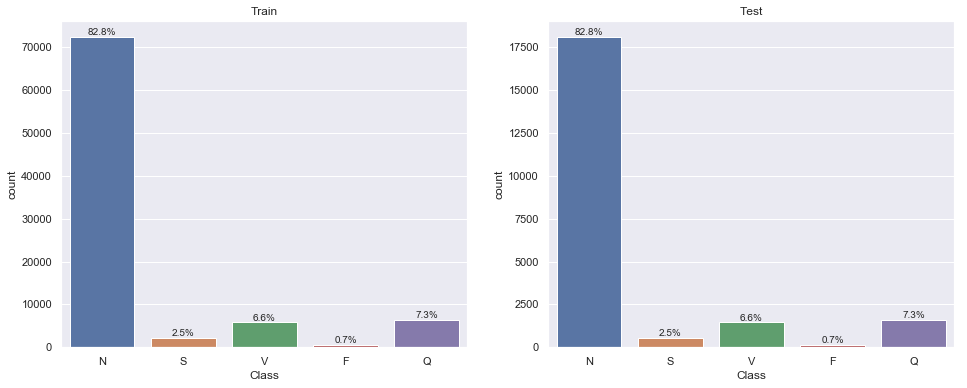

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_count(ptrain_df, 'class', ax[0], title='Train')
plot_count(ptest_df, 'class', ax[1], title='Test')

In [36]:
# delete unneccessary variables
del ptrain_df
del ptest_df

### Part 6. Feature engineering and description 

**Filter ECG signal using Butterworth filter**

The high-pass and low-pass filters together are known as a bandpass filter, literally allowing only a certain frequency band to pass through. We will use bandpass filter with cutoff=50.

In [37]:
filter_helper = FilterHelper(
    signal_frequency=125,
    filter_lowcut=0.01, 
    filter_highcut=50.0, 
    filter_order=1,
    cutoff_hz=30.,
    verbose=False, 
    log_data=False, 
    plot_data=False, 
    show_plot=False,
    save_plot=False)

filter_function = filter_helper.bandpass_filter


def calc_hr(data):
    qrsdetector = filter_helper.rr_peaks_detect(data)
    hr, i1, i2 = calculate_heart_rate(qrsdetector)
    return hr, i1, i2

A typical ECG-based heartbeat mainly consists of three waves including P-wave, QRS complex ([wiki](https://en.wikipedia.org/wiki/QRS_complex)), and T-wave. The QRS complex is the most prominent feature and it can be used to obtain additional useful clinical information from ECG signals, such as RR interval, QT interval, and PR interval, etc. Thus, QRS detection is critical for ECG-based health evaluation.

The QRS complex is the most noticeable feature in the electrocardiogram (ECG) signal, therefore, its detection is critical for ECG signal analysis.

See for more detail info - [Electrocardiography](https://en.wikipedia.org/wiki/Electrocardiography)

We use **QRSDetectorOffline** for detecting R-peaks (QRS).

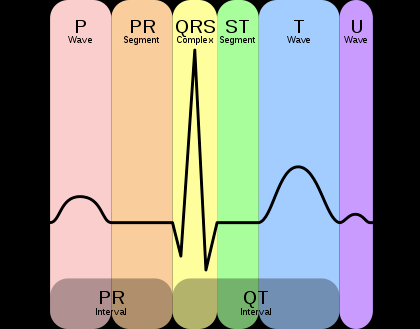

Examples of **original/filtered** ECGs with **R-peaks** (QRS)

Heart Rate: 68.80733944954129, R1: 7, R2: 116
Heart Rate: 0, R1: 7, R2: 0
Heart Rate: 0, R1: 0, R2: 0
Heart Rate: 0, R1: 7, R2: 0
Heart Rate: 0, R1: 0, R2: 0


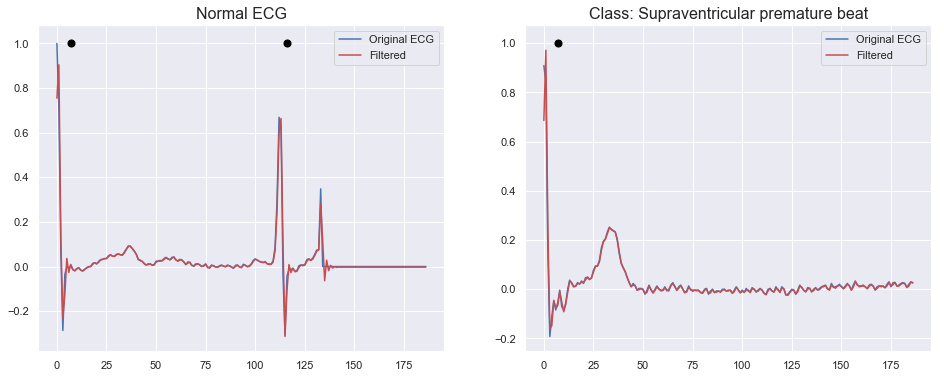

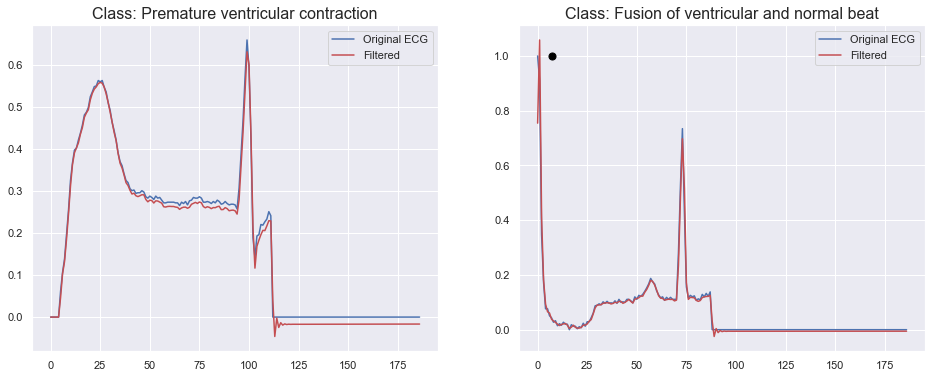

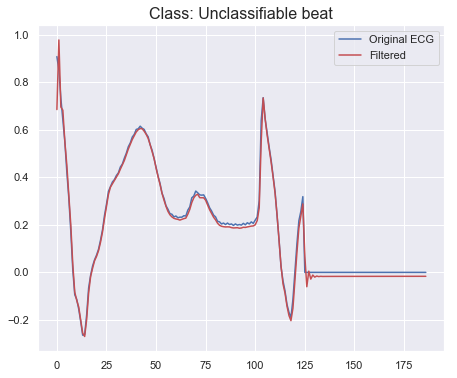

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_ecg(X_train[np.argwhere(y_train==0)[0][0], :], filter_helper, ax=axes[0],
         title='Normal ECG', 
         show_filtered=True, show_hr=True)
plot_ecg(X_train[np.argwhere(y_train==1)[0][0], :], filter_helper, ax=axes[1],
         title='Class: Supraventricular premature beat', 
         show_filtered=True, show_hr=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_ecg(X_train[np.argwhere(y_train==2)[0][0], :], filter_helper, ax=axes[0],
         title='Class: Premature ventricular contraction', 
         show_filtered=True, show_hr=True)
plot_ecg(X_train[np.argwhere(y_train==3)[0][0], :], filter_helper, ax=axes[1],
         title='Class: Fusion of ventricular and normal beat', 
         show_filtered=True, show_hr=True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_ecg(X_train[np.argwhere(y_train==4)[0][0], :], filter_helper, ax=axes[0],
         title='Class: Unclassifiable beat', 
         show_filtered=True, show_hr=True)
fig.delaxes(axes[1])

In [39]:
X_train_hr = np.apply_along_axis(calc_hr, 1, X_train)
X_test_hr = np.apply_along_axis(calc_hr, 1, X_test)

scaler_hr = StandardScaler()
X_train_hr = scaler_hr.fit_transform(X_train_hr)
X_test_hr = scaler_hr.transform(X_test_hr)

X_train_hr.shape, X_test_hr.shape

((87554, 3), (21892, 3))

In [40]:
X_train_filtered = np.apply_along_axis(filter_function, 1, X_train)
X_test_filtered = np.apply_along_axis(filter_function, 1, X_test)

**X_train_filtered, X_test_filtered - filtered data**

In [41]:
print("X_train", X_train.shape)
print("X_train_filtered", X_train_filtered.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("X_test_filtered", X_test_filtered.shape)
print("y_test", y_test.shape)

X_train (87554, 187)
X_train_filtered (87554, 187)
y_train (87554,)
X_test (21892, 187)
X_test_filtered (21892, 187)
y_test (21892,)


**Wavelets**

The wavelet transforms have the capability to allow information extraction from both frequency and time domains, which make them suitable for ECG description. The signal is decomposed using wave_decomposition function using family db1 and 3 levels.

In [42]:
def compute_wavelet_descriptor(beat, family='db1', level=3):
    """ Compute the wavelet for a ecg """
    wave_family = pywt.Wavelet(family)
    coeffs = pywt.wavedec(beat, wave_family, level=level)
    return coeffs[0]

In [43]:
X_train_wv_only = np.apply_along_axis(compute_wavelet_descriptor, 1, X_train_orig)
X_test_wv_only = np.apply_along_axis(compute_wavelet_descriptor, 1, X_test_orig)

In [44]:
scaler = StandardScaler()
X_train_wv_only_scaled = scaler.fit_transform(X_train_wv_only)
X_test_wv_only_scaled = scaler.transform(X_test_wv_only)

Heart rate feature

In [45]:
X_train_orig_hr = np.hstack([X_train_orig, X_train_hr])
X_test_orig_hr = np.hstack([X_test_orig, X_test_hr])
X_train_orig_hr.shape, X_test_orig_hr.shape

((87554, 190), (21892, 190))

In [46]:
X_train_wv_scaled = np.hstack([X_train, X_train_wv_only_scaled, X_train_hr])
X_test_wv_scaled = np.hstack([X_test, X_test_wv_only_scaled, X_test_hr])
X_train_wv_scaled.shape, X_test_wv_scaled.shape

((87554, 214), (21892, 214))

In [47]:
X_train_wv_filtered_scaled = np.hstack([X_train_filtered, X_train_wv_only_scaled, X_train_hr])
X_test_wv_filtered_scaled = np.hstack([X_test_filtered, X_test_wv_only_scaled, X_test_hr])
X_train_wv_filtered_scaled.shape, X_test_wv_filtered_scaled.shape

((87554, 214), (21892, 214))

**All our DataFrames:**

| DatFrame | Type of data |
|-|-|
| X_train_orig, X_test_orig | Original(raw) data |
| X_train, X_test | Baselined data |
| X_train_orig_hr, X_test_orig_hr | Original data + HR |
| X_train_filtered, X_test_filtered | Baselined & Filtered data |
| X_train_wv_scaled, X_test_wv_scaled | Baselined data with wavelet coefficients + HR |
| X_train_wv_filtered_scaled, X_test_wv_filtered_scaled | Baselined & Filtered data with wavelet coefficients + HR |

In [48]:
X_test_for_pred = X_test

### Part 7. Cross-validation, hyperparameter tuning

#### Some usefull model creation/training functions:

In [127]:
def grid_clf(estimator, param_grid, Xtrain, ytrain, cv, scoring='accuracy'):
    """
    CV using GridSearchCV for given estimator.
    """    
    grid_nn = GridSearchCV(estimator=estimator, scoring=scoring, param_grid=param_grid, cv=cv)
    grid_result_nn = grid_nn.fit(Xtrain, ytrain)
    
    # summarize results
    print("Best: %f using %s" % (grid_result_nn.best_score_, grid_result_nn.best_params_))
    means = grid_result_nn.cv_results_['mean_test_score']
    stds = grid_result_nn.cv_results_['std_test_score']
    params = grid_result_nn.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return grid_result_nn
    
def grid_logit_model(
    Xtrain, 
    ytrain, 
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=3),
    param_grid=None):
    """
    CV using GridSearchCV for LogisticRegression model.
    """    
    clf = LogisticRegression(
        multi_class='ovr', 
        solver='saga',
        random_state=17, 
        n_jobs=-1)

    if param_grid is None:
        Cs = [1, 0.01]
        param_grid = dict(
            C=Cs,
            multi_class=['ovr']
        )
    
    return grid_clf(clf, param_grid, Xtrain, ytrain, cv, scoring=scoring)

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
def show_total_report(ypred, ytrain, ytest, additional_title='', 
                      show_classification_report = True, show_confusion_plot=True):
    """
    Show base classification metrics.
    """    

    ohe = OneHotEncoder()
    ytrain_ = ohe.fit_transform(ytrain.reshape(-1,1))
    ytest_ = ohe.transform(ytest.reshape(-1,1))
    ypred_ = ohe.transform(ypred.reshape(-1,1))
    
    print("ranking-based average precision : {:.3f}".format(
        label_ranking_average_precision_score(ytest_.todense(), ypred_.todense())))
    print("Ranking loss : {:.3f}".format(label_ranking_loss(ytest_, ypred_.todense())))
    print("Coverage_error : {:.3f}".format(coverage_error(ytest_.todense(), ypred_.todense())))

    if show_classification_report:
        print(classification_report(ytest_.toarray().argmax(axis=1), ypred_.argmax(axis=1)))

    if show_confusion_plot:
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(ytest_.argmax(axis=1), ypred_.argmax(axis=1))
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure(figsize=(10, 10))
        plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                              title=additional_title + ' Confusion matrix, without normalization')
        plt.show()

<br>**Train LogisticRegression model**

Our base model is LogisticRegression. For the multiclass we use LogisticRegression with a one-vs-one scheme.

In [52]:
def show_clf_results(
    clf, 
    Xtest, 
    ytest, 
    ytrain,
    additional_title='',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=True):
    
    ypred = clf.predict(Xtest)
    
    if show_metrics:
        print('accuracy: {}'.format(accuracy_score(y_pred=ypred, y_true=ytest)))
        print('precision: {}'.format(precision_score(y_pred=ypred, y_true=ytest, average='macro')))    
        
    if show_classification_report or show_confusion_plot:
        show_total_report(ypred, ytrain, ytest, additional_title=additional_title, 
                          show_classification_report = show_classification_report, 
                          show_confusion_plot=show_confusion_plot)
    ypred
    
def train_logit(
    Xtrain, 
    ytrain, 
    Xtest, 
    ytest, 
    C=1,
    multi_class='ovr',
    additional_title='[Logit]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=True):
    
    logit = LogisticRegression(
        C=C,
        multi_class=multi_class, 
        random_state=17, 
        n_jobs=-1)

    logit.fit(Xtrain, ytrain)    
    
    return show_clf_results(
        logit, 
        Xtest, 
        ytest, 
        ytrain, 
        additional_title,
        show_metrics, 
        show_classification_report, 
        show_confusion_plot
    ), logit

<br>Let's try LogisticRegression with original data - it is our **baseline**.

In [77]:
%%time

X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_orig,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_logit, logit = train_logit(
    X_train_part, 
    y_train_part, 
    X_valid, 
    y_valid, 
    C=1,
    additional_title='[Logit]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False)

accuracy: 0.9054707427570716
precision: 0.8209364174767637
ranking-based average precision : 0.924
Ranking loss : 0.095
Coverage_error : 1.378
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     21752
           1       0.72      0.15      0.25       680
           2       0.65      0.32      0.43      1731
           3       0.86      0.06      0.12       194
           4       0.96      0.87      0.91      1910

   micro avg       0.91      0.91      0.91     26267
   macro avg       0.82      0.48      0.53     26267
weighted avg       0.89      0.91      0.89     26267

Wall time: 22.1 s


For base LogisticRegression with **original** data we have:

Accuracy: **0.905**

Precision: **0.821**

Ranking-based average precision : **0.924**

<br>

**HR features improve model quality:**

In [78]:
%%time
X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_orig_hr,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_logit, logit = train_logit(
    X_train_part, 
    y_train_part, 
    X_valid, 
    y_valid,  
    C=1,
    additional_title='[Logit HR]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False)

accuracy: 0.9121330947576808
precision: 0.8535542584467853
ranking-based average precision : 0.930
Ranking loss : 0.088
Coverage_error : 1.351
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     21752
           1       0.80      0.19      0.31       680
           2       0.73      0.38      0.50      1731
           3       0.86      0.09      0.17       194
           4       0.96      0.87      0.91      1910

   micro avg       0.91      0.91      0.91     26267
   macro avg       0.85      0.50      0.57     26267
weighted avg       0.90      0.91      0.90     26267

Wall time: 25.4 s


#### LogisticRegression with **Baseline+Filtered** data:

In [79]:
%%time
X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_filtered,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_logit, logit = train_logit(
    X_train_part, 
    y_train_part, 
    X_valid, 
    y_valid,  
    C=1,
    additional_title='[Logit Filtered]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False)

accuracy: 0.9109148361061408
precision: 0.8302259469666277
ranking-based average precision : 0.929
Ranking loss : 0.089
Coverage_error : 1.356
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     21752
           1       0.68      0.11      0.19       680
           2       0.72      0.40      0.51      1731
           3       0.87      0.07      0.12       194
           4       0.97      0.86      0.91      1910

   micro avg       0.91      0.91      0.91     26267
   macro avg       0.83      0.48      0.54     26267
weighted avg       0.90      0.91      0.89     26267

Wall time: 27.5 s


LogisticRegression with **Baseline+Filtered** data we have:

Accuracy: **0.911**!

Precision: **0.830**!

Ranking-based average precision : **0.929**!

So using Baseline & Filter functions improves model quality.

#### LogisticRegression with **Baselined+Filtered+Wavelet+HR** data:

In [80]:
%%time
X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_wv_filtered_scaled,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_logit, logit = train_logit(
    X_train_part, 
    y_train_part, 
    X_valid, 
    y_valid,  
    C=1,
    additional_title='[Logit BL+Filtered_WV+HR]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False)

accuracy: 0.9331480564967449
precision: 0.8816167821486298
ranking-based average precision : 0.947
Ranking loss : 0.067
Coverage_error : 1.267
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21752
           1       0.85      0.24      0.38       680
           2       0.82      0.67      0.74      1731
           3       0.82      0.07      0.13       194
           4       0.97      0.86      0.91      1910

   micro avg       0.93      0.93      0.93     26267
   macro avg       0.88      0.57      0.62     26267
weighted avg       0.93      0.93      0.92     26267

Wall time: 51.4 s


LogisticRegression with **Baselined+Filtered+Wavelet+HR** data we have:

Accuracy: **0.933!**

Precision: **0.882!**

Ranking-based average precision : **0.947!**

And Wavelets also add some improvement.

 #### LogisticRegression with **Baselined + Wavelet  + HR** data:

In [81]:
%%time
X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_wv_scaled,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_logit_flt, logit_flt = train_logit(
    X_train_part, 
    y_train_part, 
    X_valid, 
    y_valid,  
    C=1,
    additional_title='[Scaled BL+Wavelet+HR Logit]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False)

accuracy: 0.9333384094110481
precision: 0.8823551749668604
ranking-based average precision : 0.947
Ranking loss : 0.067
Coverage_error : 1.267
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21752
           1       0.86      0.25      0.39       680
           2       0.82      0.67      0.74      1731
           3       0.82      0.07      0.13       194
           4       0.97      0.87      0.92      1910

   micro avg       0.93      0.93      0.93     26267
   macro avg       0.88      0.57      0.63     26267
weighted avg       0.93      0.93      0.92     26267

Wall time: 41.8 s


For **BL + Wavelet + HR** data with LogisticRegression results are:

Accuracy: **0.933**

Precision: **0.882**

Ranking-based average precision : **0.947**


####  The number of samples in both collections is large enough for training a deep neural network!

In [131]:
class KerasModelCreator():
    def __init__(
        self, 
        feature,
        depth,
        filters=32, #32
        pool_size=5, # 5
        random_state=17):
        
        self.feature=feature
        self.depth=depth
        self.filters=filters
        self.pool_size=pool_size
        self.random_state=random_state
    
    def __call__(
        self, 
        optimizer='adam', 
        init='glorot_uniform', 
        loss='categorical_crossentropy', #'sparse_categorical_crossentropy'
        metrics=['accuracy'],
        **sk_params):
        
        seed(self.random_state)
        set_random_seed(self.random_state)

        filters=self.filters
        pool_size=self.pool_size

        inp = Input(shape=(self.feature, self.depth))
        C = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init)(inp)

        C11 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(C)
        A11 = Activation("relu")(C11)
        C12 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(A11)
        S11 = Add()([C12, C])
        A12 = Activation("relu")(S11)
        M11 = MaxPooling1D(pool_size=pool_size, strides=2)(A12)


        C21 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(M11)
        A21 = Activation("relu")(C21)
        C22 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(A21)
        S21 = Add()([C22, M11])
        A22 = Activation("relu")(S11)
        M21 = MaxPooling1D(pool_size=pool_size, strides=2)(A22)


        C31 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(M21)
        A31 = Activation("relu")(C31)
        C32 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(A31)
        S31 = Add()([C32, M21])
        A32 = Activation("relu")(S31)
        M31 = MaxPooling1D(pool_size=pool_size, strides=2)(A32)


        C41 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(M31)
        A41 = Activation("relu")(C41)
        C42 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(A41)
        S41 = Add()([C42, M31])
        A42 = Activation("relu")(S41)
        M41 = MaxPooling1D(pool_size=pool_size, strides=2)(A42)


        C51 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(M41)
        A51 = Activation("relu")(C51)
        C52 = Conv1D(filters=filters, kernel_size=5, strides=1, kernel_initializer=init, padding='same')(A51)
        S51 = Add()([C52, M41])
        A52 = Activation("relu")(S51)
        M51 = MaxPooling1D(pool_size=pool_size, strides=2)(A52)

        F1 = Flatten()(M51)

        D1 = Dense(filters, kernel_initializer=init)(F1)
        A6 = Activation("relu")(D1)
        D2 = Dense(filters, kernel_initializer=init)(A6)
        D3 = Dense(5, kernel_initializer=init)(D2)
        A7 = Softmax()(D3)

        model = Model(inputs=inp, outputs=A7)
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics, **sk_params)
        return model

In [151]:
def grid_nn_model(   
    Xtrain, 
    ytrain, 
    scoring='accuracy',
    batch_size=100,
    epochs=15,
    filters=32,
    pool_size=5,
    cv=StratifiedKFold(n_splits=3),
    param_grid=None):
    """
    CV using GridSearchCV for NN model.
    """ 
    n_obs, feature, depth = Xtrain.shape
    model_creator = KerasModelCreator(
        feature=feature, 
        depth=depth,
        filters=filters,
        pool_size=pool_size,
        random_state=17)

    clf = KerasClassifier(build_fn=model_creator, 
                          epochs=2, 
                          batch_size=batch_size, 
                          verbose=1)
    if param_grid is None:
        optimizers = ['rmsprop', 'adam']
        init = ['glorot_uniform', 'normal', 'uniform']
        metrics=[['accuracy']]#'['categorical_accuracy', 'accuracy']
        epochs = [1, 2]
        batches = [50, 100]
        param_grid = dict(
            optimizer=optimizers, 
            epochs=epochs, 
            batch_size=batches, 
            init=init,
#             metrics=metrics
        )
    
    return grid_clf(clf, param_grid, Xtrain, ytrain, cv, scoring=scoring)


In [84]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

We use sklearn wrapper from keras framework - **KerasClassifier**.

In [85]:
def train_nn_model(
    Xtrain, 
    ytrain, 
    Xtest, 
    ytest,
    batch_size=100,
    epochs=15,
    filters=32,
    pool_size=5,
    additional_title='[NN]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=True
    ):
    
    seed(17)
    set_random_seed(17)
    
    n_obs, feature, depth = Xtrain.shape
    model_creator = KerasModelCreator(
        feature=feature, 
        depth=depth,
        filters=filters,
        pool_size=pool_size,
        random_state=17)
    
    model_nn1 = KerasClassifier(
        build_fn=model_creator, 
        epochs=epochs, 
        batch_size=batch_size, 
        verbose=0)
    
    history = model_nn1.fit(Xtrain,
                        ytrain, 
                        epochs=epochs,
                        batch_size=batch_size, 
                        verbose=2, 
    #                     validation_data=(X_test, y_test_nn), 
    #                     callbacks=[lrate]
                           )
    
    return show_clf_results(
            model_nn1, 
            Xtest, 
            ytest, 
            ytrain, 
            additional_title,
            show_metrics=True, 
            show_classification_report=True, 
            show_confusion_plot=False
        ), model_nn1

In [86]:
# NN:
ohe = OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.reshape(-1,1))
y_test_nn = ohe.transform(y_test.reshape(-1,1))

In [87]:
EPOCHS = 2
BATCH_SIZE = 100

#### Our first **Deep Neural Net** with original data:

In [88]:
X_train_nn1 = np.expand_dims(X_train_orig, 2)
X_test_nn1 = np.expand_dims(X_test_orig, 2)

In [89]:
%%time

X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_nn1,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_nn1, model_nn1 = train_nn_model(
    X_train_part, 
    y_train_part, 
    X_valid, 
    y_valid, 
    additional_title='[NN]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)

Epoch 1/2
 - 130s - loss: 0.2400 - acc: 0.9319
Epoch 2/2
 - 131s - loss: 0.1076 - acc: 0.9701
accuracy: 0.9739216507404729
precision: 0.9569249530202256
ranking-based average precision : 0.979
Ranking loss : 0.026
Coverage_error : 1.104
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     21752
           1       0.96      0.58      0.72       680
           2       0.95      0.91      0.93      1731
           3       0.92      0.40      0.55       194
           4       0.98      0.97      0.98      1910

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.96      0.77      0.83     26267
weighted avg       0.97      0.97      0.97     26267

Wall time: 4min 39s


For **original** data with DNN model we have:

Accuracy: **0.974**

Precision: **0.957**

Ranking-based average precision : **0.979**

<br> Base DNN model is better than LogisticRegression.

#### NN with **Baselined+Filtered** data

In [90]:
X_train_nn2 = np.expand_dims(X_train_filtered, 2)
X_test_nn2 = np.expand_dims(X_test_filtered, 2)

In [91]:
%%time

X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_nn2,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_nn2, model_nn2 = train_nn_model(
    X_train_part, 
    y_train_part, 
    X_valid, 
    y_valid, 
    additional_title='[NN Filtered data]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)

Epoch 1/2
 - 132s - loss: 0.2441 - acc: 0.9318
Epoch 2/2
 - 131s - loss: 0.1127 - acc: 0.9689
accuracy: 0.9718658392659991
precision: 0.9586635423312254
ranking-based average precision : 0.977
Ranking loss : 0.028
Coverage_error : 1.113
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     21752
           1       0.93      0.61      0.73       680
           2       0.92      0.94      0.93      1731
           3       0.98      0.25      0.40       194
           4       0.99      0.95      0.97      1910

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.96      0.75      0.80     26267
weighted avg       0.97      0.97      0.97     26267

Wall time: 4min 40s


For DNN model with **Baselined+Filtered** data we have:

Accuracy: **0.972**

Precision: **0.957**

Ranking-based average precision : **0.977**

#### Neural Network with **Baselined+Filtered+Wavelet** data:

In [92]:
X_train_nn3 = np.expand_dims(X_train_wv_filtered_scaled, 2)
X_test_nn3 = np.expand_dims(X_test_wv_filtered_scaled, 2)

In [93]:
%%time
X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_nn3,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_nn3, model_nn3 = train_nn_model(
    X_train_part, 
    y_train_part, 
    X_valid, 
    y_valid,
    additional_title='[NN BL+Filtered+Wavelet]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)   

Epoch 1/2
 - 151s - loss: 0.2287 - acc: 0.9376
Epoch 2/2
 - 149s - loss: 0.1106 - acc: 0.9690
accuracy: 0.9722465450946054
precision: 0.9656989581896729
ranking-based average precision : 0.978
Ranking loss : 0.028
Coverage_error : 1.111
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     21752
           1       0.97      0.58      0.72       680
           2       0.89      0.94      0.92      1731
           3       1.00      0.13      0.23       194
           4       0.99      0.96      0.98      1910

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.97      0.72      0.77     26267
weighted avg       0.97      0.97      0.97     26267

Wall time: 5min 20s


For DNN model with **Baselined+Filtered+Wavelet** data we have:

Accuracy: **0.972**

Precision: **0.966**

Ranking-based average precision : **0.978**

#### Neural Network with **Filtered+Wavelet** data:

In [94]:
X_train_nn4 = np.expand_dims(X_train_wv_scaled, 2)
X_test_nn4 = np.expand_dims(X_test_wv_scaled, 2)

In [95]:
%%time
X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_nn4,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_nn4, model_nn4 = train_nn_model(
    X_train_part, 
    y_train_part, 
    X_valid, 
    y_valid,
    additional_title='[NN Filtered+Wavelet]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)   

Epoch 1/2
 - 151s - loss: 0.2278 - acc: 0.9382
Epoch 2/2
 - 150s - loss: 0.1084 - acc: 0.9699
accuracy: 0.9748734153119885
precision: 0.9596043073564061
ranking-based average precision : 0.980
Ranking loss : 0.025
Coverage_error : 1.101
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     21752
           1       0.98      0.58      0.73       680
           2       0.91      0.95      0.93      1731
           3       0.95      0.36      0.52       194
           4       0.98      0.98      0.98      1910

   micro avg       0.97      0.97      0.97     26267
   macro avg       0.96      0.77      0.83     26267
weighted avg       0.97      0.97      0.97     26267

Wall time: 5min 21s


For DNN model with **Filtered+Wavelet** data we have:

Accuracy: **0.975**

Precision: **0.960**

Ranking-based average precision : **0.980**

**LogisticRegression cross-validation**

In [96]:
skf = StratifiedKFold(n_splits=3)

In [97]:
def plot_with_err(x, mu, std, legend=False, grid=False, title=None, xlabel=None, **kwargs):
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    if legend:
        plt.legend()
    if grid:
        plt.grid(True);
    if title is not None:
        plt.title(title)
    if xlabel is not None:
        plt.xlabel(xlabel)
    
def plot_learning_curve(extimator, X, y, cv):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(estimator,
                                                  X, y, 
                                                  train_sizes=train_sizes, 
                                                  cv=cv,
                                                  scoring='accuracy')
    plot_with_err(N_train, val_train.mean(1), val_train.std(1), label='training scores')
    plot_with_err(N_train, val_test.mean(1), val_test.std(1), label='validation scores')
    plt.xlabel('Training Set Size'); 
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True);

#### LogisticRegression for our best data:

Best: 0.926151 using {'C': 2.5, 'multi_class': 'ovr'}
0.925922 (0.000660) with: {'C': 1.0, 'multi_class': 'ovr'}
0.926020 (0.000642) with: {'C': 1.25, 'multi_class': 'ovr'}
0.926053 (0.000623) with: {'C': 1.5, 'multi_class': 'ovr'}
0.926102 (0.000633) with: {'C': 1.75, 'multi_class': 'ovr'}
0.926118 (0.000639) with: {'C': 2.0, 'multi_class': 'ovr'}
0.926134 (0.000616) with: {'C': 2.25, 'multi_class': 'ovr'}
0.926151 (0.000633) with: {'C': 2.5, 'multi_class': 'ovr'}
0.926151 (0.000633) with: {'C': 2.75, 'multi_class': 'ovr'}
{'C': 2.5, 'multi_class': 'ovr'}
accuracy: 0.9282750218905852
precision: 0.8705866542786573
ranking-based average precision : 0.943
Ranking loss : 0.072
Coverage_error : 1.287
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     21752
           1       0.76      0.13      0.23       680
           2       0.83      0.65      0.73      1731
           3       0.88      0.04      0.07       194
           4       0.95

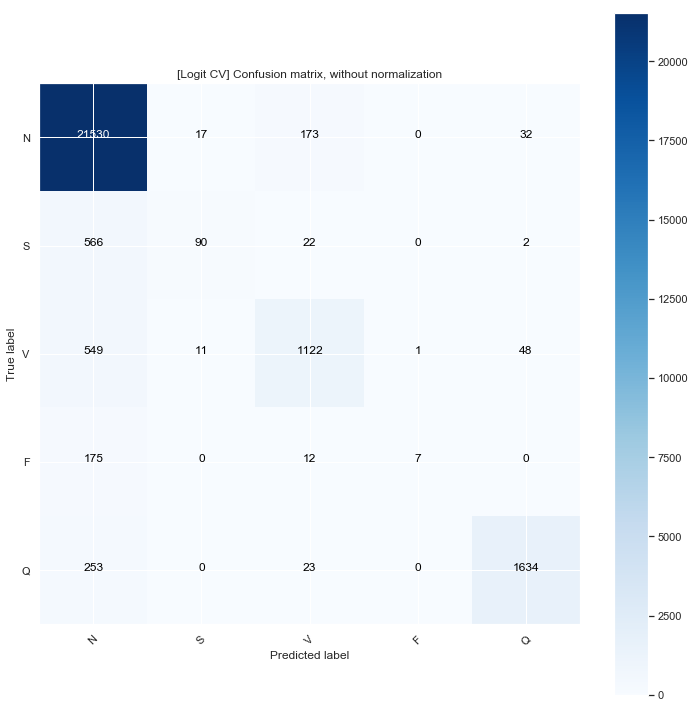

Wall time: 23min 41s


In [100]:
%%time
param_grid = dict(
            C=np.arange(1, 3, 0.25),
            multi_class=['ovr'],
        )


X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_wv_filtered_scaled,
                y_train,
                test_size=0.3,
                random_state=17)

grid_logit = grid_logit_model(
    X_train_part, 
    y_train_part, 
    cv=skf,
    param_grid=param_grid)

print(grid_logit.best_params_)

y_pred_logit_gr = show_clf_results(
        grid_logit, 
        X_valid, 
        y_valid, 
        y_train, 
        additional_title='[Logit CV]',
        show_metrics=True, 
        show_classification_report=True, 
        show_confusion_plot=True
    )

So optimal C value is **2.5**.

In [157]:
C = 2.5
grid_logit.best_params_

{'C': 2.5, 'multi_class': 'ovr'}

In [155]:
# with open('grid_logit.pkl', 'wb') as f:
#     pickle.dump(grid_logit, file=f)

**Neural Net cross-validation**

Epoch 1/1
40856/40856 [==============================] - 28s 682us/step
Epoch 1/1
40859/40859 [==============================] - 28s 680us/step
Epoch 1/1
40859/40859 [==============================] - 28s 686us/step
Epoch 1/2
40856/40856 [==============================] - 118s 3ms/step - loss: 0.2258 - acc: 0.9391
Epoch 2/2
40856/40856 [==============================] - 28s 695us/step
Epoch 1/2
40859/40859 [==============================] - 117s 3ms/step - loss: 0.2267 - acc: 0.9394
Epoch 2/2
40859/40859 [==============================] - 29s 701us/step
Epoch 1/2
40859/40859 [==============================] - 117s 3ms/step - loss: 0.2262 - acc: 0.9388
Epoch 2/2
40859/40859 [==============================] - 29s 707us/step
Epoch 1/10
40856/40856 [==============================] - 117s 3ms/step - loss: 0.2245 - acc: 0.9394
Epoch 2/10
40856/40856 [==============================] - 113s 3ms/step - loss: 0.1136 - acc: 0.9682
Epoch 3/10
40856/40856 [==============================] - 112s 3ms

40856/40856 [==============================] - 36s 876us/step
Epoch 1/30
40859/40859 [==============================] - 141s 3ms/step - loss: 0.2267 - acc: 0.9394
Epoch 2/30
40859/40859 [==============================] - 138s 3ms/step - loss: 0.1187 - acc: 0.9668 1s - loss: 0.1186 - ac
Epoch 3/30
40859/40859 [==============================] - 134s 3ms/step - loss: 0.0957 - acc: 0.9734
Epoch 4/30
40859/40859 [==============================] - 141s 3ms/step - loss: 0.0833 - acc: 0.9767
Epoch 5/30
40859/40859 [==============================] - 142s 3ms/step - loss: 0.0738 - acc: 0.9790
Epoch 6/30
40859/40859 [==============================] - 135s 3ms/step - loss: 0.0701 - acc: 0.9794
Epoch 7/30
40859/40859 [==============================] - 139s 3ms/step - loss: 0.0623 - acc: 0.9815
Epoch 8/30
40859/40859 [==============================] - 156s 4ms/step - loss: 0.0599 - acc: 0.9825 8s - loss: 0.0599 - - ETA: 
Epoch 9/30
40859/40859 [==============================] - 134s 3ms/step - loss:

40856/40856 [==============================] - 142s 3ms/step - loss: 0.0410 - acc: 0.9871
Epoch 15/50
40856/40856 [==============================] - 138s 3ms/step - loss: 0.0369 - acc: 0.9882
Epoch 16/50
40856/40856 [==============================] - 146s 4ms/step - loss: 0.0361 - acc: 0.9886
Epoch 17/50
40856/40856 [==============================] - 135s 3ms/step - loss: 0.0331 - acc: 0.9897
Epoch 18/50
40856/40856 [==============================] - 149s 4ms/step - loss: 0.0353 - acc: 0.9885
Epoch 19/50
40856/40856 [==============================] - 148s 4ms/step - loss: 0.0301 - acc: 0.9906
Epoch 20/50
40856/40856 [==============================] - 144s 4ms/step - loss: 0.0324 - acc: 0.9897
Epoch 21/50
40856/40856 [==============================] - 127s 3ms/step - loss: 0.0300 - acc: 0.9903
Epoch 22/50
40856/40856 [==============================] - 131s 3ms/step - loss: 0.0265 - acc: 0.9909
Epoch 23/50
40856/40856 [==============================] - 143s 4ms/step - loss: 0.0257 - acc:

40859/40859 [==============================] - 115s 3ms/step - loss: 0.0207 - acc: 0.9930
Epoch 42/50
40859/40859 [==============================] - 116s 3ms/step - loss: 0.0164 - acc: 0.9945
Epoch 43/50
40859/40859 [==============================] - 117s 3ms/step - loss: 0.0204 - acc: 0.9927
Epoch 44/50
40859/40859 [==============================] - 117s 3ms/step - loss: 0.0189 - acc: 0.9936
Epoch 45/50
40859/40859 [==============================] - 117s 3ms/step - loss: 0.0201 - acc: 0.9929
Epoch 46/50
40859/40859 [==============================] - 117s 3ms/step - loss: 0.0171 - acc: 0.9948
Epoch 47/50
40859/40859 [==============================] - 116s 3ms/step - loss: 0.0172 - acc: 0.9940
Epoch 48/50
40859/40859 [==============================] - 115s 3ms/step - loss: 0.0184 - acc: 0.9940
Epoch 49/50
40859/40859 [==============================] - 115s 3ms/step - loss: 0.0178 - acc: 0.9937
Epoch 50/50
40859/40859 [==============================] - 30s 740us/step
Epoch 1/50
40859/408

61287/61287 [==============================] - 174s 3ms/step - loss: 0.0335 - acc: 0.9894
Epoch 20/30
61287/61287 [==============================] - 174s 3ms/step - loss: 0.0294 - acc: 0.9904
Epoch 21/30
61287/61287 [==============================] - 174s 3ms/step - loss: 0.0300 - acc: 0.9906
Epoch 22/30
61287/61287 [==============================] - 174s 3ms/step - loss: 0.0290 - acc: 0.9906
Epoch 23/30
61287/61287 [==============================] - 174s 3ms/step - loss: 0.0271 - acc: 0.9910
Epoch 24/30
61287/61287 [==============================] - 174s 3ms/step - loss: 0.0263 - acc: 0.9914
Epoch 25/30
61287/61287 [==============================] - 174s 3ms/step - loss: 0.0254 - acc: 0.9913
Epoch 26/30
61287/61287 [==============================] - 174s 3ms/step - loss: 0.0248 - acc: 0.9916
Epoch 27/30
61287/61287 [==============================] - 174s 3ms/step - loss: 0.0256 - acc: 0.9916
Epoch 28/30
61287/61287 [==============================] - 175s 3ms/step - loss: 0.0266 - acc:

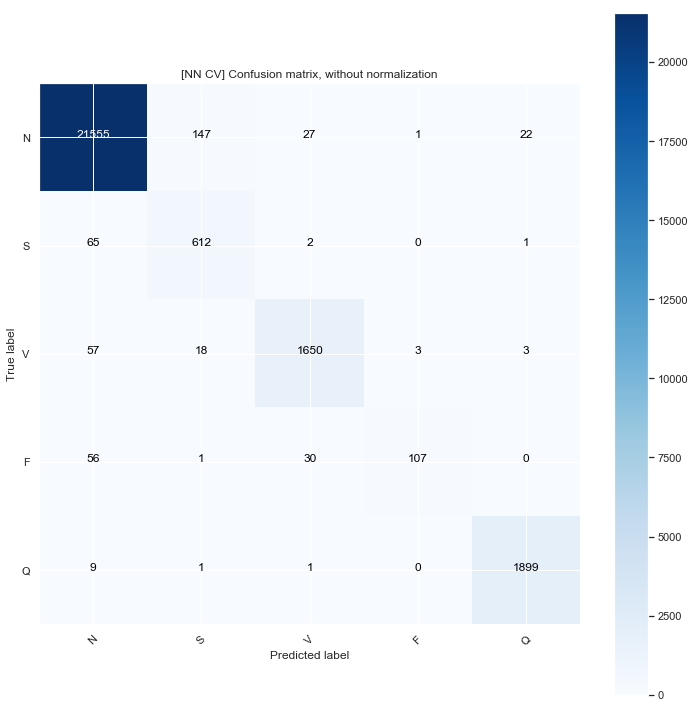

Wall time: 19h 29min 12s


In [152]:
%%time

X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_nn3,
                y_train,
                test_size=0.3,
                random_state=17)

param_nn_grid = dict(
    epochs=[1, 2, 10, 30, 50], 
    batch_size=[50], 
)

grid_nn = grid_nn_model(
    X_train_part, 
    y_train_part, 
    cv=StratifiedKFold(n_splits=3),
    param_grid=param_nn_grid)

grid_nn.best_params_

y_pred_nn_gr = show_clf_results(
        grid_nn, 
        X_valid, 
        y_valid, 
        y_train, 
        additional_title='[NN CV]',
        show_metrics=True, 
        show_classification_report=True, 
        show_confusion_plot=True
    )

**So optimal epochs value is 30**

In [156]:
grid_nn.best_params_

{'batch_size': 50, 'epochs': 30}

In [154]:
# with open('grid_nn.pkl', 'wb') as f:
#     pickle.dump(grid_nn, file=f)

### Part 8. Validation and learning curves

#### LogisticRegression validation/learning curves

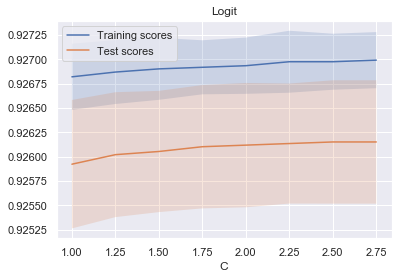

In [106]:
plot_with_err(grid_logit.param_grid['C'], 
              grid_logit.cv_results_['mean_train_score'], 
              grid_logit.cv_results_['std_train_score'], 
              legend=True,
              grid=True,
              xlabel='C',
              label='Training scores')
plot_with_err(grid_logit.param_grid['C'], 
              grid_logit.cv_results_['mean_test_score'], 
              grid_logit.cv_results_['std_test_score'], 
              legend=True, 
              grid=True,
              xlabel='C',
              title='Logit',
              label='Test scores')

#### NN validation/learning curves

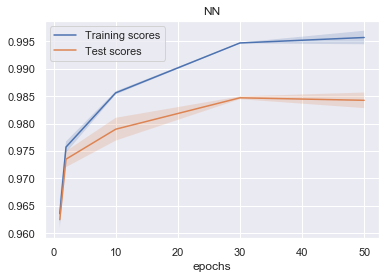

In [153]:
plot_with_err(grid_nn.param_grid['epochs'], 
              grid_nn.cv_results_['mean_train_score'], 
              grid_nn.cv_results_['std_train_score'], 
              legend=True,
              grid=True,
              xlabel='epochs',
              label='Training scores')
plot_with_err(grid_nn.param_grid['epochs'], 
              grid_nn.cv_results_['mean_test_score'], 
              grid_nn.cv_results_['std_test_score'], 
              legend=True, 
              grid=True,
              xlabel='epochs',
              title='NN',
              label='Test scores')

### Part 9. Prediction for hold-out and test samples 

#### Build model using full train data:

In [166]:
%%time
# grid_logit_full = grid_logit.fit(
#     X_train_wv_filtered_scaled,
#     y_train)
# our train/valid for logit
X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_wv_filtered_scaled,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_logit_full, grid_logit_full = train_logit(
    X_train_wv_filtered_scaled, 
    y_train, 
    X_test_wv_filtered_scaled, 
    y_test,  
    C=grid_logit.best_params_['C'],
    additional_title='[Logit BL+Filtered_WV+HR]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False)

accuracy: 0.9343595834094647
precision: 0.9077003888540084
ranking-based average precision : 0.947
Ranking loss : 0.066
Coverage_error : 1.263
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     18118
           1       0.90      0.26      0.41       556
           2       0.82      0.67      0.73      1448
           3       0.92      0.14      0.24       162
           4       0.97      0.86      0.91      1608

   micro avg       0.93      0.93      0.93     21892
   macro avg       0.91      0.58      0.65     21892
weighted avg       0.93      0.93      0.93     21892

Wall time: 1min 54s


**LogisticRegresion hold-out results:**

accuracy: 0.9355465032169642
precision: 0.9014655778079025
ranking-based average precision : 0.948
Ranking loss : 0.064
Coverage_error : 1.258
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     21752
           1       0.86      0.29      0.44       680
           2       0.83      0.68      0.75      1731
           3       0.90      0.09      0.17       194
           4       0.97      0.87      0.92      1910

   micro avg       0.94      0.94      0.94     26267
   macro avg       0.90      0.58      0.65     26267
weighted avg       0.93      0.94      0.93     26267

Confusion matrix, without normalization


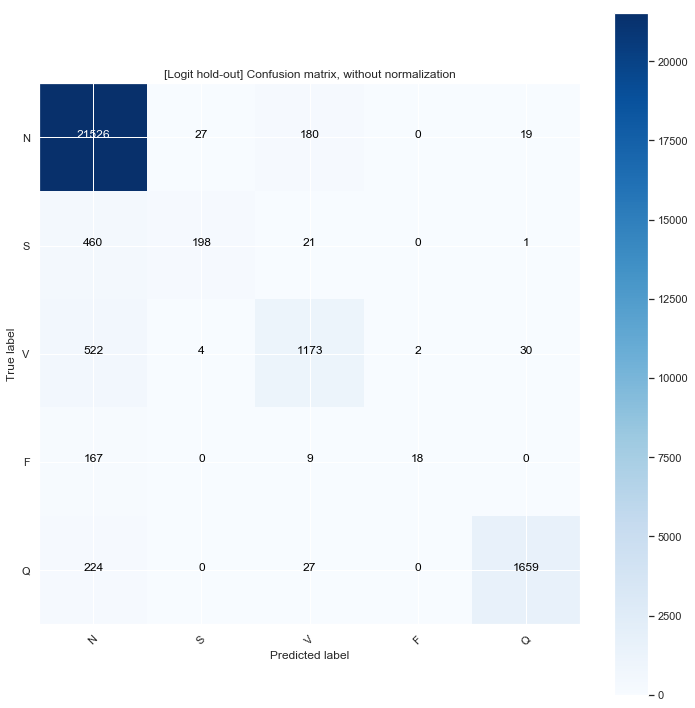

In [167]:
y_pred_logit_valid_full = show_clf_results(
        grid_logit_full, 
        X_valid, 
        y_valid, 
        y_train, 
        additional_title='[Logit hold-out]',
        show_metrics=True, 
        show_classification_report=True, 
        show_confusion_plot=True
    )

**LogisticRegresion test results:**

accuracy: 0.9343595834094647
precision: 0.9077003888540084
ranking-based average precision : 0.947
Ranking loss : 0.066
Coverage_error : 1.263
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     18118
           1       0.90      0.26      0.41       556
           2       0.82      0.67      0.73      1448
           3       0.92      0.14      0.24       162
           4       0.97      0.86      0.91      1608

   micro avg       0.93      0.93      0.93     21892
   macro avg       0.91      0.58      0.65     21892
weighted avg       0.93      0.93      0.93     21892

Confusion matrix, without normalization


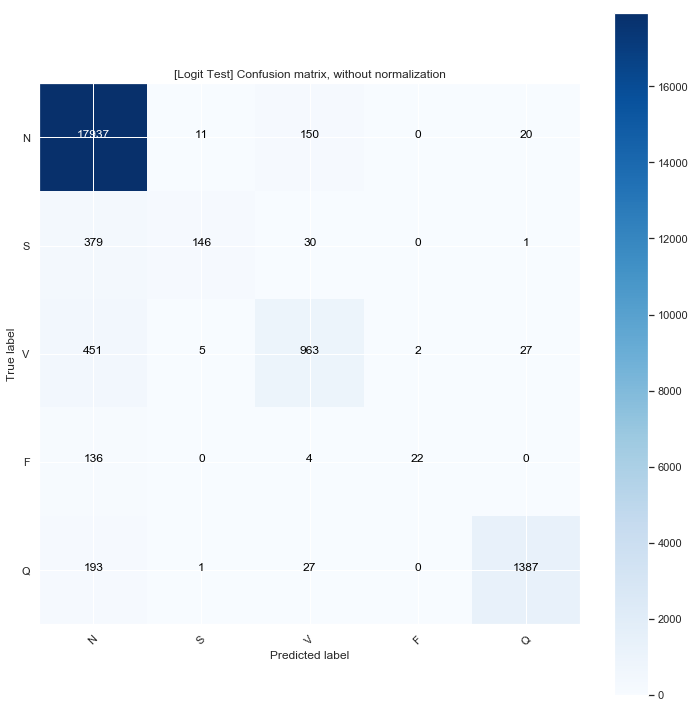

In [168]:
y_pred_logit_test_full = show_clf_results(
        grid_logit_full, 
        X_test_wv_filtered_scaled,
        y_test,
        y_train,
        additional_title='[Logit Test]',
        show_metrics=True, 
        show_classification_report=True, 
        show_confusion_plot=True
    )

<br>

#### Build NN model using full train data:

In [174]:
%%time
X_train_part, X_valid, y_train_part, y_valid = \
        train_test_split(
                X_train_nn3,
                y_train,
                test_size=0.3,
                random_state=17)

y_pred_nn3_full, grid_nn_full = train_nn_model(
    X_train_nn3, 
    y_train, 
    X_test_nn3,
    y_test,
    additional_title='[NN BL+Filtered+Wavelet]',
    show_metrics=True, 
    show_classification_report=True, 
    show_confusion_plot=False,
    batch_size=grid_nn.best_params_['batch_size'], 
    epochs=grid_nn.best_params_['epochs'])

Epoch 1/30
 - 313s - loss: 0.1712 - acc: 0.9536
Epoch 2/30
 - 326s - loss: 0.0887 - acc: 0.9751
Epoch 3/30
 - 317s - loss: 0.0741 - acc: 0.9789
Epoch 4/30
 - 317s - loss: 0.0656 - acc: 0.9809
Epoch 5/30
 - 313s - loss: 0.0578 - acc: 0.9829
Epoch 6/30
 - 297s - loss: 0.0546 - acc: 0.9845
Epoch 7/30
 - 311s - loss: 0.0497 - acc: 0.9851
Epoch 8/30
 - 315s - loss: 0.0465 - acc: 0.9860
Epoch 9/30
 - 322s - loss: 0.0443 - acc: 0.9866
Epoch 10/30
 - 315s - loss: 0.0422 - acc: 0.9872
Epoch 11/30
 - 308s - loss: 0.0398 - acc: 0.9879
Epoch 12/30
 - 304s - loss: 0.0372 - acc: 0.9885
Epoch 13/30
 - 297s - loss: 0.0370 - acc: 0.9886
Epoch 14/30
 - 307s - loss: 0.0354 - acc: 0.9890
Epoch 15/30
 - 305s - loss: 0.0341 - acc: 0.9890
Epoch 16/30
 - 320s - loss: 0.0326 - acc: 0.9896
Epoch 17/30
 - 257s - loss: 0.0318 - acc: 0.9900
Epoch 18/30
 - 254s - loss: 0.0304 - acc: 0.9900
Epoch 19/30
 - 255s - loss: 0.0315 - acc: 0.9899
Epoch 20/30
 - 255s - loss: 0.0302 - acc: 0.9902
Epoch 21/30
 - 255s - loss: 0

**NN hold-out results:**

accuracy: 0.9915864011878022
precision: 0.974773019695248
ranking-based average precision : 0.993
Ranking loss : 0.008
Coverage_error : 1.034
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21752
           1       0.98      0.83      0.90       680
           2       0.97      0.99      0.98      1731
           3       0.93      0.80      0.86       194
           4       1.00      1.00      1.00      1910

   micro avg       0.99      0.99      0.99     26267
   macro avg       0.97      0.92      0.95     26267
weighted avg       0.99      0.99      0.99     26267

Confusion matrix, without normalization


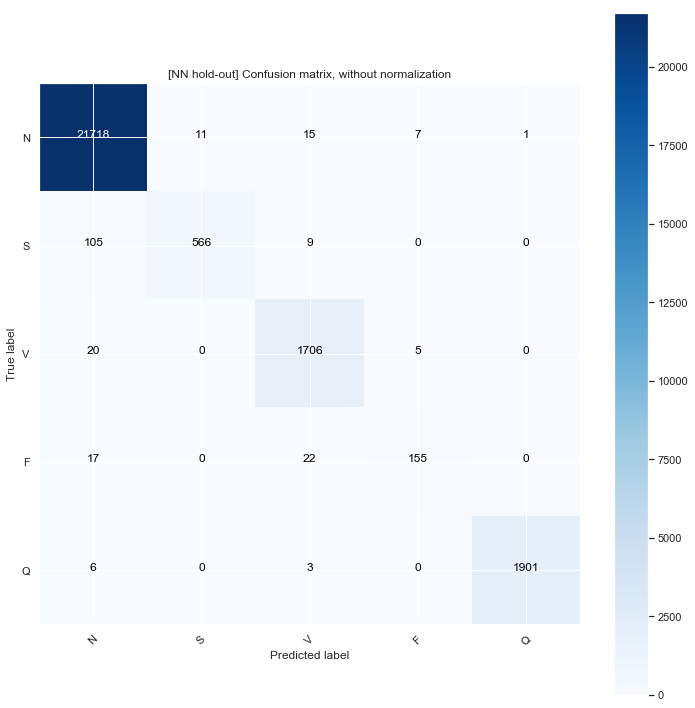

In [175]:
y_pred_nn_valid_full = show_clf_results(
        grid_nn_full, 
        X_valid, 
        y_valid, 
        y_train, 
        additional_title='[NN hold-out]',
        show_metrics=True, 
        show_classification_report=True, 
        show_confusion_plot=True
    )

**NN test results:**

accuracy: 0.9846519276448018
precision: 0.9433570033155041
ranking-based average precision : 0.988
Ranking loss : 0.015
Coverage_error : 1.061
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18118
           1       0.91      0.75      0.82       556
           2       0.95      0.96      0.95      1448
           3       0.88      0.73      0.80       162
           4       0.99      0.99      0.99      1608

   micro avg       0.98      0.98      0.98     21892
   macro avg       0.94      0.89      0.91     21892
weighted avg       0.98      0.98      0.98     21892

Confusion matrix, without normalization


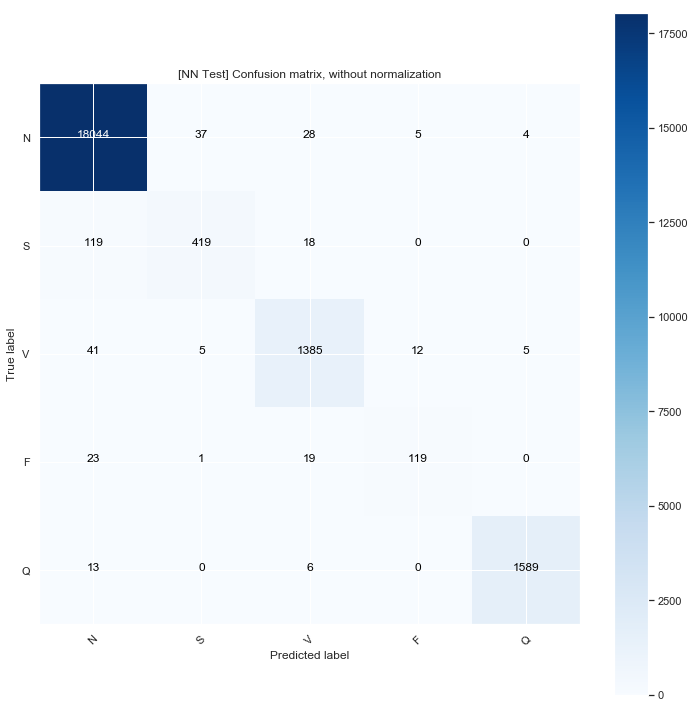

In [179]:
grid_nn_test_full = show_clf_results(
        grid_nn_full, 
        X_test_nn3,
        y_test,
        y_train,
        additional_title='[NN Test]',
        show_metrics=True, 
        show_classification_report=True, 
        show_confusion_plot=True
    )

### Part 10. Model evaluation with metrics description

We use accuracy metrics in our model. In medical diagnosis, test sensitivity is the ability of a test to correctly identify those with the disease - [wiki](https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Medical_examples), so we will also use **precision** metric (we calculate other classification metrics, such as f1-score, ...).

For LogisticRegression we get accuracy=0.934, precision=0.908 for test data. But NN is much better - accuracy=0.985, precision=0.943.

### Part 11. Conclusions

Deep Neural Network model's accuracy is 0.968! It is perfect result. 

But we can improve our model, some ideas for improvement:
* Use additional ECG features, such as P, Q, R, S, T waves
* Our data is inbalanced, so try data oversampling (see data augmentation above)
* Using original ECG will be better solution (in our current DB we have only 'one R-peaks')
* Use FFT analysis
* Tune hyperparameters (Neural Network tuning need powewfull hardware)
* Try another models (SVM, ...)




